<div class="row">
    <div class="column">
        <img src="logos/metpy_400x400.png" width=125 alt="MetPy Logo"></img>
    </div>
    <div class="column">
        <img src="logos/unidata_logo_horizontal.png" width=250 alt="Unidata Logo"></img>
    </div>
</div>

# MetPy for analysis and visualization of diverse data

---

## Overview

MetPy is a collection of tools for reading, managing, analyzing, and visualizing weather data in Python. MetPy is built within and upon the open scientific Python ecosystem, utilizing popular tools like Pandas, Xarray, Cartopy, Pyproj, and more!

Today, we will dive straight in with a crash course on MetPy for the basics of units, data management, and plotting with MetPy. We will end the day with a final plot summarizing multiple data types and calculations alongside previously generated wind retrievals from PyDDA.

## Outline
1. Crash Course to MetPy
    1. Units and `metpy.calc`
    2. `metpy.io` for reading data
    3. Plotting SkewT's and Station Plots
    4. xarray + MetPy and CF Conventions
2. Final Analysis

---

## Imports

In [1]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyart.io
import xarray as xr


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



## Crash Course to MetPy

### Units and calculations

MetPy requires units for correctness and unit-aware analysis across the package through the use of [Pint](https://pint.readthedocs.io/en/stable/). We can get started with an import and defining our first `Quantity`.

In [2]:
from metpy.units import units

In [3]:
miles = units.Quantity(3.5, "miles")
hour = 0.5 * units.hr
# Those are the same!

print(miles, hour)

3.5 mile 0.5 hour


In [4]:
speed = miles / hour
speed

7.0 <Unit('mile / hour')>

Pint gives us a variety of helpful methods for converting and reducing units.

In [5]:
speed.to("m/s")

3.1292800000000005 <Unit('meter / second')>

Temperature is a common one! Watch out for `degC` vs. `C`.

In [6]:
temp_outside = 25 * units.degC
temp_increase = 2.5 * units.degC

temp_outside + temp_increase

OffsetUnitCalculusError: Ambiguous operation with offset unit (degree_Celsius, degree_Celsius). See https://pint.readthedocs.io/en/stable/user/nonmult.html for guidance.

What the heck happened there?

In [7]:
temp_inside = 21 * units.degC

temp_outside - temp_inside

4 <Unit('delta_degree_Celsius')>

In [8]:
temp_increase = 2.5 * units.delta_degC

temp_outside + temp_increase

27.5 <Unit('degree_Celsius')>

This can save you from weird errors and science headaches, and all of MetPy's calculations require units and process the information for you throughout your workflows.

In [9]:
import metpy.calc as mpcalc

In [10]:
u = 30 * units.knots
v = 5 * units.kg

mpcalc.wind_direction(u, v)

ValueError: `wind_direction` given arguments with incorrect units: `v` requires "[speed]" but given "kilogram"

In [11]:
u = 10 * units.kts
v = 5 * units("m/s")

mpcalc.wind_direction(u, v)

array(225.81576649) <Unit('degree')>

### MetPy for annoying data you love

The title says it all.

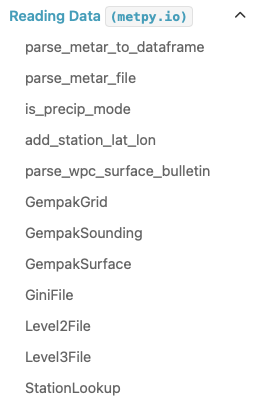

Let's start with a classic, METARs.

In [12]:
from metpy.io import parse_metar_file

In [13]:
df = pd.read_csv("../../data/metpy/asos.csv")
df.head()

,KMDQ 110000Z AUTO 16013G19KT 10SM SCT047 OVC050 25/15 A2985 RMK AO2 LTG DSNT NW
0,KMDQ 110020Z AUTO 17009G17KT 10SM SCT048 BKN06...
1,KMDQ 110040Z AUTO 16010G16KT 10SM BKN044 BKN05...
2,METAR KHSV 110053Z 17014KT 10SM BKN040 BKN055 ...
3,KDCU 110053Z AUTO 17013G20KT 10SM FEW060 23/17...
4,KMDQ 110100Z AUTO 17010G17KT 10SM SCT044 SCT04...


Now, that's not particularly helpful. But I know there's some meaningful information in those reports. Let's parse it.

In [14]:
metars = parse_metar_file("../../data/metpy/asos.csv", month=4, year=2008).set_index("date_time")
metars

,station_id,latitude,longitude,elevation,wind_direction,wind_speed,wind_gust,visibility,current_wx1,current_wx2,...,air_temperature,dew_point_temperature,altimeter,current_wx1_symbol,current_wx2_symbol,current_wx3_symbol,remarks,air_pressure_at_sea_level,eastward_wind,northward_wind
date_time,,,,,,,,,,,,,,,,,,,,,
2008-04-11 00:00:00,KMDQ,34.86,-86.55,230,160,13.0,19.0,16093.44,NaN,NaN,...,25.0,15.0,29.85,0,0,0,AO2 LTG DSNT NW,1010.12,-4.446262e+00,12.216004
2008-04-11 00:20:00,KMDQ,34.86,-86.55,230,170,9.0,17.0,16093.44,NaN,NaN,...,25.0,15.0,29.85,0,0,0,AO2,1010.12,-1.562834e+00,8.863270
2008-04-11 00:40:00,KMDQ,34.86,-86.55,230,160,10.0,16.0,16093.44,NaN,NaN,...,25.0,15.0,29.85,0,0,0,AO2,1010.12,-3.420201e+00,9.396926
2008-04-11 00:53:00,KHSV,34.65,-86.78,191,170,14.0,NaN,16093.44,NaN,NaN,...,24.0,17.0,29.86,0,0,0,AO2 SLP106 T02440167,1010.72,-2.431074e+00,13.787309
2008-04-11 00:53:00,KDCU,34.65,-86.95,176,170,13.0,20.0,16093.44,NaN,NaN,...,23.0,17.0,29.84,0,0,0,AO2 SLP100 T02330172,1010.17,-2.257426e+00,12.802501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-04-11 22:53:00,KHSV,34.65,-86.78,191,230,9.0,NaN,16093.44,NaN,NaN,...,21.0,12.0,29.79,0,0,0,AO2 SLP082 T02110122,1008.57,6.894400e+00,5.785088
2008-04-11 23:00:00,KMDQ,34.86,-86.55,230,200,8.0,NaN,16093.44,NaN,NaN,...,21.0,16.0,29.78,0,0,0,AO2,1008.10,2.736161e+00,7.517541
2008-04-11 23:20:00,KMDQ,34.86,-86.55,230,190,7.0,NaN,16093.44,NaN,NaN,...,20.0,13.0,29.77,0,0,0,AO2 LTG DSNT E AND S,1007.85,1.215537e+00,6.893654


Much better! Now we can use pandas for all of the subsetting and exploration we're used to.

In [15]:
subset = metars.loc["2008-04-11 18:25:00": "2008-04-11 18:40:00"]
subset

,station_id,latitude,longitude,elevation,wind_direction,wind_speed,wind_gust,visibility,current_wx1,current_wx2,...,air_temperature,dew_point_temperature,altimeter,current_wx1_symbol,current_wx2_symbol,current_wx3_symbol,remarks,air_pressure_at_sea_level,eastward_wind,northward_wind
date_time,,,,,,,,,,,,,,,,,,,,,
2008-04-11 18:30:00,KDCU,34.65,-86.95,176,220,10.0,28.0,11265.408,-TSRA,NaN,...,23.0,19.0,29.75,1095,0,0,AO2 PK WND 20030/1820 LTG DSNT ALQDS TSB24RAB0...,1007.11,6.427876,7.660444
2008-04-11 18:40:00,KMDQ,34.86,-86.55,230,190,21.0,26.0,11265.408,-VCTSRA,NaN,...,24.0,18.0,29.74,1095,0,0,AO2 LTG DSNT ALQS,1006.47,3.646612,20.680963


And we can discover a wealth of parsed information available to us for analysis and plotting later.

In [16]:
subset.columns

Index(['station_id', 'latitude', 'longitude', 'elevation', 'wind_direction',
       'wind_speed', 'wind_gust', 'visibility', 'current_wx1', 'current_wx2',
       'current_wx3', 'low_cloud_type', 'low_cloud_level', 'medium_cloud_type',
       'medium_cloud_level', 'high_cloud_type', 'high_cloud_level',
       'highest_cloud_type', 'highest_cloud_level', 'cloud_coverage',
       'air_temperature', 'dew_point_temperature', 'altimeter',
       'current_wx1_symbol', 'current_wx2_symbol', 'current_wx3_symbol',
       'remarks', 'air_pressure_at_sea_level', 'eastward_wind',
       'northward_wind'],
      dtype='object')

### MetPy for plots you love

Speaking of, we'll leave our METARs behind for now, but let's explore what making plots can look like with MetPy. First, a fan favorite: Skew T diagrams! Let's explore the 12Z sounding out of Birmingham on the day of our case study.

In [17]:
df = pd.read_fwf("../../data/sounding_data/bmx_sounding_20080411_12Z.txt")
df

,-----------------------------------------------------------------------------
0,PRES HGHT TEMP DWPT RELH MIXR DRCT...
1,hPa m C C % g/kg deg ...
2,----------------------------------------------...
3,1000.0 110
4,993.0 178 19.0 17.0 88 12.42 16...
...,...
136,10.5 30480 -47.4 -82.4 1 0.04 310...
137,10.0 30780 -47.5 -82.5 1 0.04 280...
138,8.7 31716 -39.5 -76.5 1 0.13 ...
139,8.7 31699 -39.6 -76.6 1 0.13 275 ...


One more, not particularly helpful. With some exploration and copying and pasting from the file, we can clean up our dataframe a bit.

In [18]:
names_header = "   PRES   HGHT   TEMP   DWPT   RELH   MIXR   DRCT   SKNT   THTA   THTE   THTV"

# slight tweak
units_header = "    hPa     m      degC      degC      %    g/kg    deg   knot     K      K      K "

df = pd.read_fwf("../../data/sounding_data/bmx_sounding_20080411_12Z.txt",
                header=None, skiprows=4, names=names_header.split())
df

,PRES,HGHT,TEMP,DWPT,RELH,MIXR,DRCT,SKNT,THTA,THTE,THTV
0,1000.0,110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,993.0,178,19.0,17.0,88.0,12.42,160.0,9.0,292.7,328.2,294.9
2,988.0,221,18.8,16.6,87.0,12.17,164.0,11.0,293.0,327.8,295.1
3,959.0,474,17.0,16.6,97.0,12.54,187.0,23.0,293.6,329.6,295.9
4,943.7,610,17.1,16.8,98.0,12.94,200.0,29.0,295.1,332.4,297.4
...,...,...,...,...,...,...,...,...,...,...,...
133,10.5,30480,-47.4,-82.4,1.0,0.04,310.0,12.0,830.5,831.1,830.6
134,10.0,30780,-47.5,-82.5,1.0,0.04,280.0,7.0,841.1,841.7,841.1
135,8.7,31716,-39.5,-76.5,1.0,0.13,NaN,NaN,906.3,908.1,906.4
136,8.7,31699,-39.6,-76.6,1.0,0.13,275.0,14.0,905.1,906.8,905.1


That's a good start. Let's get rid of a bunch of our missing data,

In [19]:
df = df.dropna(subset=('TEMP', 'DWPT', 'DRCT', 'SKNT'), how="all").reset_index(drop=True)
df

,PRES,HGHT,TEMP,DWPT,RELH,MIXR,DRCT,SKNT,THTA,THTE,THTV
0,993.0,178,19.0,17.0,88.0,12.42,160.0,9.0,292.7,328.2,294.9
1,988.0,221,18.8,16.6,87.0,12.17,164.0,11.0,293.0,327.8,295.1
2,959.0,474,17.0,16.6,97.0,12.54,187.0,23.0,293.6,329.6,295.9
3,943.7,610,17.1,16.8,98.0,12.94,200.0,29.0,295.1,332.4,297.4
4,926.0,770,17.2,17.1,99.0,13.43,205.0,35.0,296.8,335.8,299.2
...,...,...,...,...,...,...,...,...,...,...,...
132,10.5,30480,-47.4,-82.4,1.0,0.04,310.0,12.0,830.5,831.1,830.6
133,10.0,30780,-47.5,-82.5,1.0,0.04,280.0,7.0,841.1,841.7,841.1
134,8.7,31716,-39.5,-76.5,1.0,0.13,NaN,NaN,906.3,908.1,906.4
135,8.7,31699,-39.6,-76.6,1.0,0.13,275.0,14.0,905.1,906.8,905.1


Now, a tool you might not require often, but can save you some time when you do. Combining pandas with units! Let's start by constructing a `dict` of our unit strings that matches each of the columns of `df`.

In [20]:
from metpy.units import pandas_dataframe_to_unit_arrays

units_dict = {col: unit for col, unit in zip(names_header.split(), units_header.split())}
units_dict

{'PRES': 'hPa',
 'HGHT': 'm',
 'TEMP': 'degC',
 'DWPT': 'degC',
 'RELH': '%',
 'MIXR': 'g/kg',
 'DRCT': 'deg',
 'SKNT': 'knot',
 'THTA': 'K',
 'THTE': 'K',
 'THTV': 'K'}

Now with those...

In [21]:
data = pandas_dataframe_to_unit_arrays(df, units_dict)
data["PRES"]

Magnitude,[993.0 988.0 959.0 943.7 926.0 925.0 916.0 910.5 906.0 878.4 850.0 845.0 817.2 788.0 787.0 781.0 778.0 773.0 765.0 762.0 759.7 744.0 742.0 737.0 734.0 732.2 719.0 705.6 705.0 700.0 680.0 679.0 677.0 675.0 674.0 672.0 657.0 654.8 654.0 652.0 645.0 640.0 628.0 626.0 619.0 616.0 607.0 594.0 579.0 570.0 562.0 500.0 499.9 480.2 443.1 430.0 414.0 408.0 400.0 391.8 360.0 350.0 316.2 304.0 300.0 278.0 256.0 250.0 226.0 215.0 211.0 210.0 209.4 202.0 200.0 187.0 181.1 181.0 167.0 164.2 163.0 152.0 150.0 148.8 141.6 140.0 136.0 129.0 128.1 124.0 121.8 121.0 115.0 113.0 110.0 108.0 100.0 85.2 83.6 82.1 81.0 80.6 77.0 73.1 70.0 68.4 66.0 65.2 64.5 59.7 56.1 52.6 50.0 48.2 44.3 44.0 42.6 39.1 37.7 36.2 34.5 32.0 30.2 30.0 26.9 26.3 20.0 17.2 16.7 16.0 13.2 11.4 10.5 10.0 8.7 8.7 8.4]
Units,hectopascal


Of course, you can tackle this by hand for each column whenever you need.

In [22]:
df["PRES"].values * units.hPa

Magnitude,[993.0 988.0 959.0 943.7 926.0 925.0 916.0 910.5 906.0 878.4 850.0 845.0 817.2 788.0 787.0 781.0 778.0 773.0 765.0 762.0 759.7 744.0 742.0 737.0 734.0 732.2 719.0 705.6 705.0 700.0 680.0 679.0 677.0 675.0 674.0 672.0 657.0 654.8 654.0 652.0 645.0 640.0 628.0 626.0 619.0 616.0 607.0 594.0 579.0 570.0 562.0 500.0 499.9 480.2 443.1 430.0 414.0 408.0 400.0 391.8 360.0 350.0 316.2 304.0 300.0 278.0 256.0 250.0 226.0 215.0 211.0 210.0 209.4 202.0 200.0 187.0 181.1 181.0 167.0 164.2 163.0 152.0 150.0 148.8 141.6 140.0 136.0 129.0 128.1 124.0 121.8 121.0 115.0 113.0 110.0 108.0 100.0 85.2 83.6 82.1 81.0 80.6 77.0 73.1 70.0 68.4 66.0 65.2 64.5 59.7 56.1 52.6 50.0 48.2 44.3 44.0 42.6 39.1 37.7 36.2 34.5 32.0 30.2 30.0 26.9 26.3 20.0 17.2 16.7 16.0 13.2 11.4 10.5 10.0 8.7 8.7 8.4]
Units,hectopascal


But let's go back to the unit array dictionary we created above, and pull out our Skew T relevant quantities.

In [23]:
p = data["PRES"]
t = data["TEMP"]
td = data["DWPT"]

And sneak in a calculation to convert from wind speed and direction to u- and v-components of our wind vectors.

In [24]:
u, v = mpcalc.wind_components(data["SKNT"], data["DRCT"])

In [25]:
u

Magnitude,[-3.07818128993102 -3.0320109139869915 2.802994898318388 9.91858415644439 14.791639160924476 14.791639160924476 15.636875684405872 16.059493946146574 16.658103577984942 17.500000000000004 21.22232814498871 21.22232814498871 20.64875170863766 25.45584412271571 25.45584412271571 26.615572612530094 27.060086959909302 28.239503368140987 28.678964048465335 29.875733281640137 29.875733281640137 29.845352611981507 29.016315039426466 28.83363526931848 28.2865209231697 28.578838324886465 30.376660163930527 30.909626441250186 30.909626441250186 30.909626441250186 33.09315014597609 32.88924172750679 33.828934348292705 33.828934348292705 33.60889535389926 33.60889535389926 35.628272848061435 35.34600369442935 35.34600369442935 35.05296780566751 34.749254443346345 33.55200852863923 32.57235742668026 32.57235742668026 32.22582765394419 31.030811013980696 30.30862563869269 30.732419390662162 31.697802369356424 32.1795628712435 31.819805153394636 38.971143170299726 40.78385041664925 41.56921938165304 38.500146081582606 40.95760221444958 44.234210391605544 45.872514480183526 47.510818568761515 49.96827470162849 62.35382907247956 61.716045650552076 58.159795144518405 61.716045650552076 62.35382907247956 66.22106946441953 71.00472965763417 72.504622962932 82.51936305644406 86.82297966423974 89.2707989746613 89.2707989746613 89.2707989746613 84.57233587073176 83.63264324994584 77.9944875252304 75.17540966287268 75.17540966287268 81.75325800837403 83.63264324994584 82.26011607714057 68.48568446325122 65.74885007405521 64.01250394579353 45.3153893518325 45.838496361257505 49.00535883036023 52.82754963085074 53.69357503463518 51.095498823281865 50.229473419497424 50.229473419497424 46.96555180494375 45.597066490527304 44.234210391605544 43.68691769624716 39.068266599067876 44.31634888554936 35.90094187221187 27.732837922928024 21.612930278075893 19.77346901858167 2.952019020337818 13.765834472425109 16.086933305498537 14.41681763465924 11.276311449430901 9.620816778533356 7.986355100472928 -0.43577871373829097 1.9294614907189929 6.156614753256582 9.8298245314679 11.883216824898845 -3.3991869381244215 -4.648800879147694 -4.694715627858908 -5.2900672706322585 -5.034563128398699 -4.77398852043749 -5.119475911334193 -4.045084971874737 -3.4286692028084493 -3.4641016151377544 -3.105828541230249 -3.9068178534858804 -11.2763114494309 -4.890738003669028 -3.939231012048832 -4.635919272833937 -2.070552360820166 4.822082614679855 9.192533317427738 6.893654271085457 nan 13.946725773284438 nan]
Units,knot


Units! Alright, let's dive in to a Skew T.

In [26]:
from metpy.plots import SkewT

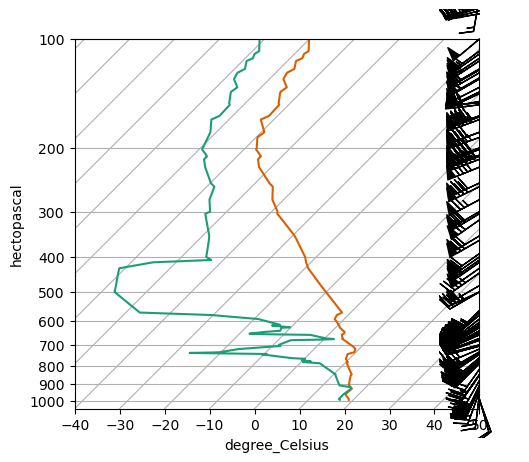

In [27]:
fig = plt.figure()

skew = SkewT(fig, rotation=45)

orangeish = "#d95f02"
greenish = "#1b9e77"

skew.plot(p, t, color=orangeish)
skew.plot(p, td, color=greenish)

skew.plot_barbs(p, u , v)

/var/folders/3f/3w3flt9x5rd9y8zbsc7cvvzw0000gp/T/ipykernel_64625/1653287333.py:14: UserWarning: Duplicate pressure(s) [8.7] hPa provided. Output profile includes duplicate temperatures as a result.
  prof = mpcalc.parcel_profile(p, t[0], td[0]).to('degC')


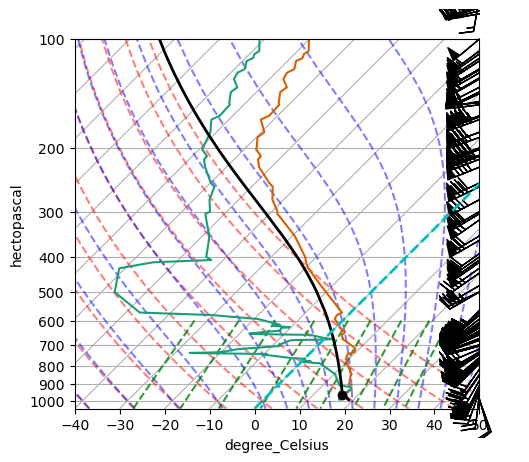

In [28]:
fig = plt.figure()

skew = SkewT(fig, rotation=45)

skew.plot(p, t, color=orangeish)
skew.plot(p, td, color=greenish)

skew.plot_barbs(p, u , v)

lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], t[0], td[0])
skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')

# Calculate full parcel profile and add to plot as black line
prof = mpcalc.parcel_profile(p, t[0], td[0]).to('degC')
skew.plot(p, prof, 'k', linewidth=2)

# An example of a slanted line at constant T -- in this case the 0
# isotherm
skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)

# Add the relevant special lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

Now for something slightly different. Let's show construction of a station plot, which we'll use for our final plot at the end.

In [29]:
from metpy.plots import StationPlot, sky_cover, current_weather

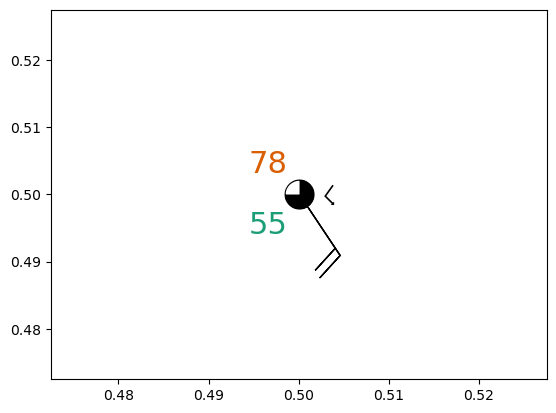

In [30]:
fig, ax = plt.subplots()

stationplot = StationPlot(ax, 0.5, 0.5, fontsize=22)
stationplot.plot_parameter("NW", [78], color=orangeish)
stationplot.plot_parameter("SW", [55], color=greenish)
stationplot.plot_symbol("C", [6], sky_cover)
stationplot.plot_symbol("E", [13], current_weather)
stationplot.plot_barb([-10], [15])

### xarray, CF conventions, and MetPy

With the power of the internet, let's use [Siphon](https://unidata.github.io/siphon/latest/) + Unidata's [THREDDS Data Server](https://www.unidata.ucar.edu/software/tds/) (TDS) at NOAA PSL to access some North American Regional Reanalysis (NARR) data.

In [31]:
from siphon.catalog import TDSCatalog
cat = TDSCatalog("https://psl.noaa.gov/thredds/catalog/Datasets/NARR/Dailies/pressure/catalog.xml")

In [32]:
len(cat.datasets)

3745

In [33]:
cat.datasets[0:10]

[air.197901.nc,
 air.197902.nc,
 air.197903.nc,
 air.197904.nc,
 air.197905.nc,
 air.197906.nc,
 air.197907.nc,
 air.197908.nc,
 air.197909.nc,
 air.197910.nc]

Let's take a closer look at our case study period, April 2008.

In [34]:
[data for data in cat.datasets if "200804" in data]

['air.200804.nc',
 'hgt.200804.nc',
 'omega.200804.nc',
 'shum.200804.nc',
 'tke.200804.nc',
 'uwnd.200804.nc',
 'vwnd.200804.nc']

We won't need all of those. With a little Python-fu (or, really, "list comprehensions"), we can trim this down one last time.

In [35]:
variables = [var+".200804.nc" for var in ['air', 'shum', 'uwnd', 'vwnd']]
variables

['air.200804.nc', 'shum.200804.nc', 'uwnd.200804.nc', 'vwnd.200804.nc']

The TDS gives us a variety of methods and services for accessing the underlying data.

In [36]:
cat.datasets["air.200804.nc"].access_urls

{'OpenDAP': 'https://psl.noaa.gov/thredds/dodsC/Datasets/NARR/Dailies/pressure/air.200804.nc',
 'HTTPServer': 'https://psl.noaa.gov/thredds/fileServer/Datasets/NARR/Dailies/pressure/air.200804.nc',
 'WCS': 'https://psl.noaa.gov/thredds/wcs/Datasets/NARR/Dailies/pressure/air.200804.nc',
 'WMS': 'https://psl.noaa.gov/thredds/wms/Datasets/NARR/Dailies/pressure/air.200804.nc',
 'NetcdfSubset': 'https://psl.noaa.gov/thredds/ncss/grid/Datasets/NARR/Dailies/pressure/air.200804.nc',
 'ISO': 'https://psl.noaa.gov/thredds/iso/Datasets/NARR/Dailies/pressure/air.200804.nc',
 'NCML': 'https://psl.noaa.gov/thredds/ncml/Datasets/NARR/Dailies/pressure/air.200804.nc',
 'UDDC': 'https://psl.noaa.gov/thredds/uddc/Datasets/NARR/Dailies/pressure/air.200804.nc'}

Let's go get those OPeNDAP links, which we know xarray will appreciate

In [37]:
urls = [cat.datasets[data].access_urls["OpenDAP"] for data in variables]
urls

['https://psl.noaa.gov/thredds/dodsC/Datasets/NARR/Dailies/pressure/air.200804.nc',
 'https://psl.noaa.gov/thredds/dodsC/Datasets/NARR/Dailies/pressure/shum.200804.nc',
 'https://psl.noaa.gov/thredds/dodsC/Datasets/NARR/Dailies/pressure/uwnd.200804.nc',
 'https://psl.noaa.gov/thredds/dodsC/Datasets/NARR/Dailies/pressure/vwnd.200804.nc']

In [38]:
ds = xr.open_mfdataset(urls)
ds

/Users/dcamron/mambaforge/envs/ams-open-radar-2023-dev/lib/python3.11/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Users/dcamron/mambaforge/envs/ams-open-radar-2023-dev/lib/python3.11/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'shum' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Users/dcamron/mambaforge/envs/ams-open-radar-2023-dev/lib/python3.11/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'uwnd' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Users/dcamron/mambaforge/envs/ams-open-radar-2023-dev/lib/python3.11/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'vwnd' has multiple fill values {9.96921e+36, -9.96921e+36

<xarray.Dataset>
Dimensions:            (time: 30, level: 29, y: 277, x: 349, nbnds: 2)
Coordinates:
  * time               (time) datetime64[ns] 2008-04-01 ... 2008-04-30
  * level              (level) float32 1e+03 975.0 950.0 ... 150.0 125.0 100.0
  * y                  (y) float32 0.0 3.246e+04 ... 8.927e+06 8.96e+06
  * x                  (x) float32 0.0 3.246e+04 ... 1.126e+07 1.13e+07
    lat                (y, x) float32 dask.array<chunksize=(277, 349), meta=np.ndarray>
    lon                (y, x) float32 dask.array<chunksize=(277, 349), meta=np.ndarray>
Dimensions without coordinates: nbnds
Data variables:
    Lambert_Conformal  int32 -2147483647
    time_bnds          (time, nbnds) float64 dask.array<chunksize=(30, 2), meta=np.ndarray>
    air                (time, level, y, x) float32 dask.array<chunksize=(30, 29, 277, 349), meta=np.ndarray>
    shum               (time, level, y, x) float32 dask.array<chunksize=(30, 29, 277, 349), meta=np.ndarray>
    uwnd               (time, level, y, x) float32 dask.array<chunksize=(30, 29, 277, 349), meta=np.ndarray>
    vwnd               (time, level, y, x) float32 dask.array<chunksize=(30, 29, 277, 349), meta=np.ndarray>
Attributes: (12/17)
    Conventions:                     CF-1.2
    centerlat:                       50.0
    centerlon:                       -107.0
    comments:                        
    institution:                     National Centers for Environmental Predi...
    latcorners:                      [ 1.000001  0.897945 46.3544   46.63433 ]
    ...                              ...
    history:                         created Fri Mar 25 10:26:27 MDT 2016 by ...
    dataset_title:                   NCEP North American Regional Reanalysis ...
    references:                      https://www.esrl.noaa.gov/psd/data/gridd...
    source:                          http://www.emc.ncep.noaa.gov/mmb/rreanl/...
    _NCProperties:                   version=2,netcdf=4.6.3,hdf5=1.10.5
    DODS_EXTRA.Unlimited_Dimension:  time

Let's trim that down to just our day of interest. For today's exercise, we want to step out of dask land to avoid some quirks of MetPy + dask. Note, you can use MetPy with dask, but you will have to learn those quirks (and we will have to erode at them with our development time!).

In [39]:
ds = ds.sel(time="2008-04-11")
ds.load() # to de-daskify. Be careful with this for larger datasets!

<xarray.Dataset>
Dimensions:            (level: 29, y: 277, x: 349, nbnds: 2)
Coordinates:
    time               datetime64[ns] 2008-04-11
  * level              (level) float32 1e+03 975.0 950.0 ... 150.0 125.0 100.0
  * y                  (y) float32 0.0 3.246e+04 ... 8.927e+06 8.96e+06
  * x                  (x) float32 0.0 3.246e+04 ... 1.126e+07 1.13e+07
    lat                (y, x) float32 1.0 1.104 1.208 ... 46.93 46.64 46.35
    lon                (y, x) float32 -145.5 -145.3 -145.1 ... -2.644 -2.57
Dimensions without coordinates: nbnds
Data variables:
    Lambert_Conformal  int32 -2147483647
    time_bnds          (nbnds) float64 1.826e+06 1.826e+06
    air                (level, y, x) float32 297.1 297.2 297.2 ... nan nan nan
    shum               (level, y, x) float32 0.01619 0.01612 0.01609 ... nan nan
    uwnd               (level, y, x) float32 -4.334 -4.334 -4.642 ... nan nan
    vwnd               (level, y, x) float32 -5.029 -5.029 -4.98 ... nan nan nan
Attributes: (12/17)
    Conventions:                     CF-1.2
    centerlat:                       50.0
    centerlon:                       -107.0
    comments:                        
    institution:                     National Centers for Environmental Predi...
    latcorners:                      [ 1.000001  0.897945 46.3544   46.63433 ]
    ...                              ...
    history:                         created Fri Mar 25 10:26:27 MDT 2016 by ...
    dataset_title:                   NCEP North American Regional Reanalysis ...
    references:                      https://www.esrl.noaa.gov/psd/data/gridd...
    source:                          http://www.emc.ncep.noaa.gov/mmb/rreanl/...
    _NCProperties:                   version=2,netcdf=4.6.3,hdf5=1.10.5
    DODS_EXTRA.Unlimited_Dimension:  time

Check out the MetPy + xarray [tutorial on our documentation](https://unidata.github.io/MetPy/latest/tutorials/xarray_tutorial.html), but here's an introduction to the `.metpy` accessor for working with xarray data.

In [40]:
ds["air"].metpy.vertical

<xarray.DataArray 'level' (level: 29)>
array([1000.,  975.,  950.,  925.,  900.,  875.,  850.,  825.,  800.,  775.,
        750.,  725.,  700.,  650.,  600.,  550.,  500.,  450.,  400.,  350.,
        300.,  275.,  250.,  225.,  200.,  175.,  150.,  125.,  100.],
      dtype=float32)
Coordinates:
    time     datetime64[ns] 2008-04-11
  * level    (level) float32 1e+03 975.0 950.0 925.0 ... 175.0 150.0 125.0 100.0
Attributes:
    GRIB_id:             100
    GRIB_name:           hPa
    actual_range:        [1000.  100.]
    axis:                Z
    coordinate_defines:  point
    long_name:           Level
    positive:            down
    standard_name:       level
    units:               millibar
    _metpy_axis:         vertical

In [41]:
ds["air"].metpy.x

<xarray.DataArray 'x' (x: 349)>
array([       0.,    32463.,    64926., ..., 11232200., 11264660., 11297120.],
      dtype=float32)
Coordinates:
    time     datetime64[ns] 2008-04-11
  * x        (x) float32 0.0 3.246e+04 6.493e+04 ... 1.126e+07 1.13e+07
Attributes:
    long_name:      eastward distance from southwest corner of domain in proj...
    standard_name:  projection_x_coordinate
    units:          m
    _metpy_axis:    x

In [42]:
ds["air"].metpy.sel(vertical=650 * units.hPa,
                    x=600 * units.km,
                    y=400000 * units.m,
                    method="nearest")

<xarray.DataArray 'air' ()>
array(276.60437, dtype=float32)
Coordinates:
    time     datetime64[ns] 2008-04-11
    level    float32 650.0
    y        float32 3.896e+05
    x        float32 5.843e+05
    lat      float32 5.175
    lon      float32 -143.3
Attributes: (12/14)
    GRIB_id:        11
    GRIB_name:      TMP
    grid_mapping:   Lambert_Conformal
    level_desc:     Pressure Levels
    standard_name:  air_temperature
    units:          degK
    ...             ...
    dataset:        NARR Daily Averages
    long_name:      Daily Air Temperature on Pressure Levels
    parent_stat:    Individual Obs
    statistic:      Mean
    actual_range:   [190.62566 312.67166]
    _ChunkSizes:    [  1   1 277 349]

We can revisit our old friend units here, too.

In [43]:
ds["air"].metpy.units

<Unit('kelvin')>

In [44]:
ds["air"].metpy.convert_units("degC")

Magnitude,[[[23.965545654296875 24.000701904296875 24.008514404296875 ... nan nan nan] [23.926483154296875 23.957733154296875 23.979217529296875 ... nan nan nan] [23.822967529296875 23.852264404296875 23.887420654296875 ... nan nan nan] ... [nan nan nan ... nan nan nan] [nan nan nan ... nan nan nan] [nan nan nan ... nan nan nan]] [[21.999114990234375 22.024505615234375 22.018646240234375 ... nan nan nan] [21.934661865234375 21.958099365234375 21.962005615234375 ... nan nan nan] [21.825286865234375 21.805755615234375 21.835052490234375 ... nan nan nan] ... [nan nan nan ... nan nan nan] [nan nan nan ... nan nan nan] [nan nan nan ... nan nan nan]] [[20.197601318359375 20.213226318359375 20.211273193359375 ... nan nan nan] [20.144866943359375 20.148773193359375 20.178070068359375 ... nan nan nan] [20.066741943359375 20.055023193359375 20.080413818359375 ... nan nan nan] ... [nan nan nan ... nan nan nan] [nan nan nan ... nan nan nan] [nan nan nan ... nan nan nan]] ... [[-66.97174072265625 -66.94635009765625 -66.91705322265625 ... nan nan nan] [-66.94244384765625 -66.91510009765625 -66.87994384765625 ... nan nan nan] [-66.91314697265625 -66.87994384765625 -66.85064697265625 ... nan nan nan] ... [nan nan nan ... nan nan nan] [nan nan nan ... nan nan nan] [nan nan nan ... nan nan nan]] [[-72.83016967773438 -72.78720092773438 -72.75399780273438 ... nan nan nan] [-72.80868530273438 -72.76766967773438 -72.73446655273438 ... nan nan nan] [-72.79110717773438 -72.75204467773438 -72.71884155273438 ... nan nan nan] ... [nan nan nan ... nan nan nan] [nan nan nan ... nan nan nan] [nan nan nan ... nan nan nan]] [[-77.89239501953125 -77.91387939453125 -77.93731689453125 ... nan nan nan] [-77.93145751953125 -77.95684814453125 -77.97833251953125 ... nan nan nan] [-77.97833251953125 -77.99981689453125 -78.01739501953125 ... nan nan nan] ... [nan nan nan ... nan nan nan] [nan nan nan ... nan nan nan] [nan nan nan ... nan nan nan]]]
Units,degree_Celsius


If you're working with data that follow the [Climate and Forecasting (CF) Metadata Conventions](http://cfconventions.org), MetPy can understand that metadata and make it more Python friendly for you.

In [45]:
ds = ds.metpy.parse_cf()
ds

<xarray.Dataset>
Dimensions:            (nbnds: 2, level: 29, y: 277, x: 349)
Coordinates:
    time               datetime64[ns] 2008-04-11
  * level              (level) float32 1e+03 975.0 950.0 ... 150.0 125.0 100.0
  * y                  (y) float32 0.0 3.246e+04 ... 8.927e+06 8.96e+06
  * x                  (x) float32 0.0 3.246e+04 ... 1.126e+07 1.13e+07
    lat                (y, x) float32 1.0 1.104 1.208 ... 46.93 46.64 46.35
    lon                (y, x) float32 -145.5 -145.3 -145.1 ... -2.644 -2.57
    metpy_crs          object Projection: lambert_conformal_conic
Dimensions without coordinates: nbnds
Data variables:
    Lambert_Conformal  int32 -2147483647
    time_bnds          (nbnds) float64 1.826e+06 1.826e+06
    air                (level, y, x) float32 297.1 297.2 297.2 ... nan nan nan
    shum               (level, y, x) float32 0.01619 0.01612 0.01609 ... nan nan
    uwnd               (level, y, x) float32 -4.334 -4.334 -4.642 ... nan nan
    vwnd               (level, y, x) float32 -5.029 -5.029 -4.98 ... nan nan nan
Attributes: (12/17)
    Conventions:                     CF-1.2
    centerlat:                       50.0
    centerlon:                       -107.0
    comments:                        
    institution:                     National Centers for Environmental Predi...
    latcorners:                      [ 1.000001  0.897945 46.3544   46.63433 ]
    ...                              ...
    history:                         created Fri Mar 25 10:26:27 MDT 2016 by ...
    dataset_title:                   NCEP North American Regional Reanalysis ...
    references:                      https://www.esrl.noaa.gov/psd/data/gridd...
    source:                          http://www.emc.ncep.noaa.gov/mmb/rreanl/...
    _NCProperties:                   version=2,netcdf=4.6.3,hdf5=1.10.5
    DODS_EXTRA.Unlimited_Dimension:  time

In [46]:
ds["air"].metpy.cartopy_crs

<Projected CRS: +proj=lcc +ellps=sphere +lon_0=-107.0 +lat_0=50.0  ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Lambert Conic Conformal (2SP)
Datum: Unknown based on Normal Sphere (r=6370997) ellipsoid
- Ellipsoid: Normal Sphere (r=6370997)
- Prime Meridian: Greenwich

We'll take a step back to select across our entire dataset for some calculations.

In [47]:
ds = ds.sel(level=650)

In [48]:
mpcalc.dewpoint_from_specific_humidity?

Signature:
mpcalc.dewpoint_from_specific_humidity(
    pressure,
    temperature,
    specific_humidity,
)
Docstring:
Calculate the dewpoint from specific humidity, temperature, and pressure.

Parameters
----------
pressure: `pint.Quantity`
    Total atmospheric pressure

temperature: `pint.Quantity`
    Air temperature

specific_humidity: `pint.Quantity`
    Specific humidity of air

Returns
-------
`pint.Quantity`
    Dew point temperature

Examples
--------
>>> from metpy.calc import dewpoint_from_specific_humidity
>>> from metpy.units import units
>>> dewpoint_from_specific_humidity(1000 * units.hPa, 10 * units.degC, 5 * units('g/kg'))
<Quantity(3.73203192, 'degree_Celsius')>

.. versionchanged:: 1.0
   Changed signature from ``(specific_humidity, temperature, pressure)``

See Also
--------
relative_humidity_from_mixing_ratio, dewpoint_from_relative_humidity
File:      ~/mambaforge/envs/ams-open-radar-2023-dev/lib/python3.11/site-packages/metpy/calc/thermo.py
Type:      function

In [49]:
dewpoint = mpcalc.dewpoint_from_specific_humidity(ds.level, ds.air, ds.shum)
dewpoint

Magnitude,[[-7.744659423828125 -7.75494384765625 -7.762786865234375 ... nan nan nan] [-7.705780029296875 -7.711151123046875 -7.721405029296875 ... nan nan nan] [-7.664642333984375 -7.669464111328125 -7.677215576171875 ... nan nan nan] ... [nan nan nan ... nan nan nan] [nan nan nan ... nan nan nan] [nan nan nan ... nan nan nan]]
Units,degree_Celsius


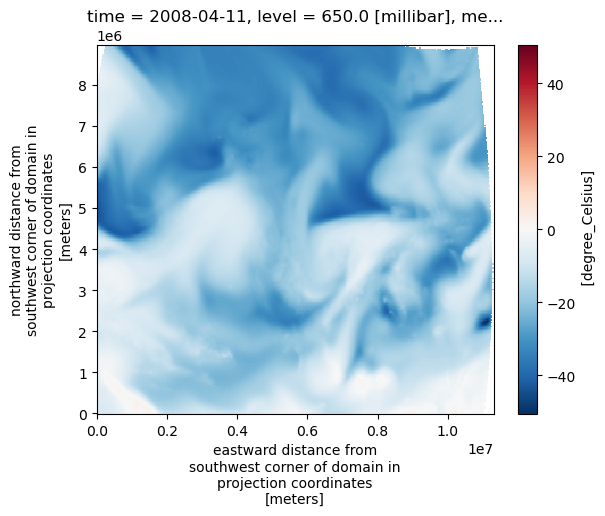

In [50]:
dewpoint.plot()

## Putting it all together

In [51]:
khtx_file = "../pydda/output_grid_KHTX.nc"
armor_file = "../pydda/output_grid_ARMOR.nc"

In [52]:
khtx_ds = pyart.io.read_grid(khtx_file).to_xarray().sel(z=3000).squeeze()
armor_ds = pyart.io.read_grid(armor_file).to_xarray().sel(z=3000).squeeze()

/Users/dcamron/mambaforge/envs/ams-open-radar-2023-dev/lib/python3.11/site-packages/pyart/io/cfradial.py:408: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  data = self.ncvar[:]
/Users/dcamron/mambaforge/envs/ams-open-radar-2023-dev/lib/python3.11/site-packages/pyart/io/cfradial.py:408: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  data = self.ncvar[:]
/Users/dcamron/mambaforge/envs/ams-open-radar-2023-dev/lib/python3.11/site-packages/pyart/io/cfradial.py:408: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  data = self.ncvar[:]
/Users/dcamron/mambaforge/envs/ams-open-radar-2023-dev/lib/python3.11/site-packages/pyart/io/cfradial.py:408: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  data = self.ncvar[:]


Text(0.5, 1.0, 'Retrieved winds, ASOS reports, and NARR calculated dewpoint')

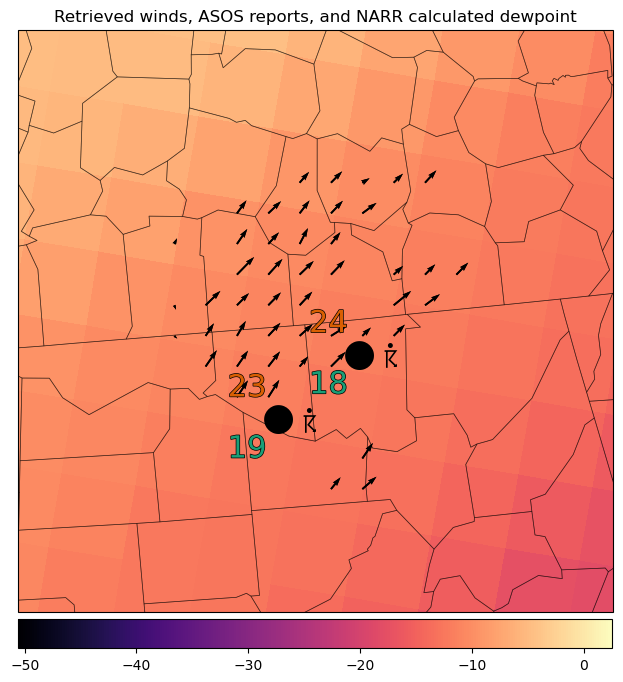

In [53]:
from metpy.plots import USCOUNTIES
from matplotlib.patheffects import withStroke

# Setting up our figure and desired map projection with Cartopy
fig, ax = plt.subplots(figsize=(9, 9), subplot_kw={"projection": ccrs.LambertConformal()})

ax.set_extent((-88, -85.5, 34, 36), crs=ccrs.PlateCarree())

# Starting with our calculated dewpoint from remotely accessed NARR data
cf = ax.pcolormesh(dewpoint.metpy.x, dewpoint.metpy.y, dewpoint,
                 transform=dewpoint.metpy.cartopy_crs, cmap="magma")

# Plot our PyDDA retrieved winds from KHTX and ARMOR as quivers
ax.quiver(khtx_ds.lon.data, khtx_ds.lat.data,
          khtx_ds.u.data, khtx_ds.v.data,
          transform=ccrs.PlateCarree(),
          regrid_shape=20)

ax.quiver(armor_ds.lon.data, armor_ds.lat.data,
          armor_ds.u.data, armor_ds.v.data,
          transform=ccrs.PlateCarree(),
          regrid_shape=20)

# Include DCU and MDQ ASOS reports as station plots with 
# temperature, dewpoint, cloud cover, and current weather reports
stationplot = StationPlot(ax, subset["longitude"], subset["latitude"],
                          transform=ccrs.PlateCarree(), clip_on=True, fontsize=22)

stationplot.plot_parameter("NW", subset["air_temperature"], color=orangeish,
                           path_effects=[withStroke(linewidth=1, foreground="black")])
stationplot.plot_parameter("SW", subset["dew_point_temperature"],color=greenish,
                           path_effects=[withStroke(linewidth=1, foreground="black")])
stationplot.plot_symbol("C", subset["cloud_coverage"], sky_cover)
stationplot.plot_symbol("E", subset["current_wx1_symbol"], current_weather)

# Use Cartopy + MetPy for county outlines, helpful at this scale
ax.add_feature(USCOUNTIES, alpha=0.5, linewidth=0.5)

# Some final touching up, and...
fig.colorbar(cf, orientation="horizontal", pad=0.01, shrink=0.852)

ax.set_title("""Retrieved winds, ASOS reports, and NARR calculated dewpoint""")

---

## Resources and references
- [MetPy Documentation](https://unidata.github.io/MetPy/latest/)
- [MetPy Support](https://unidata.github.io/MetPy/latest/userguide/SUPPORT.html)
- [MetPy Cookbook](https://projectpythia.org/metpy-cookbook/) (under construction, contribute today!)